Decision Trees
===

Load the dataset

In [16]:
%matplotlib inline
import sklearn

from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

# breast cancer dataset
# {
#   target_names: ['malignant', 'benign'],
#   feature_names: [
#     'mean radius',
#     'mean texture',
#     'mean perimeter',
#     'mean area',
#     ...
#   ],
#   data: [
#     [1.79900000e+01, 1.03800000e+01, ...],
#     ...
#   ],
#   target: [0, 1, ...]
# }

Withold test data from the training set

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

Evaluate the decision tree model

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


Pre-pruning the tree to avoid overfitting

In [19]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


Export to a .dot file format (text file format for storing graphs)

In [20]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"], 
                feature_names=cancer.feature_names, impurity=False, filled=True)

Import the .dot file

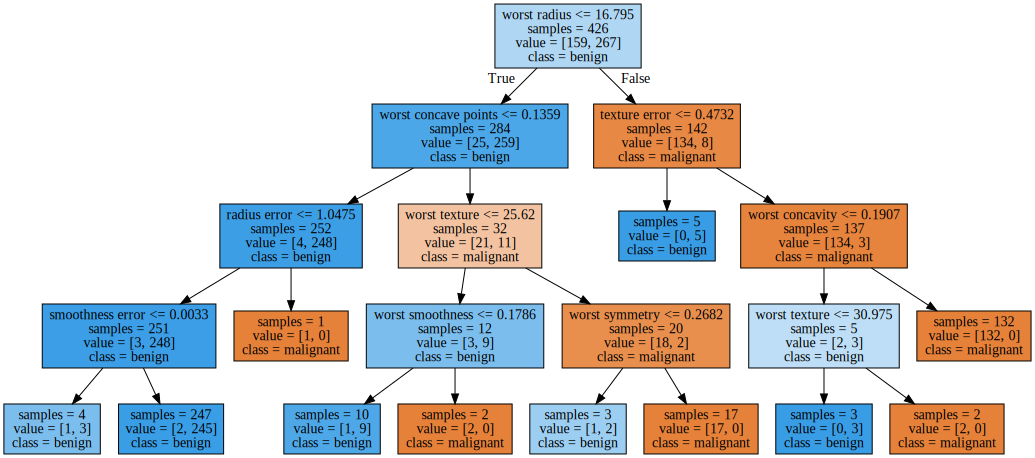

In [21]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

Inspect the tree by examining the path that most of the data takes by looking at `n_samples` in each node.  `value` provides the number of samples per class (malignant, benign).

Taking the right path, nearly all of the malignant tumors end in the far right node.  Taking the left path, nearly all of the benign tumors end in the second node.

Feature Importance to summarize trees
---

Rates each feature from 0 to 1 where 0 is "not used at all" and 1 "perfectly predicts the target".  Feature importance always sums to 1.

In [22]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


Visualize feature importance

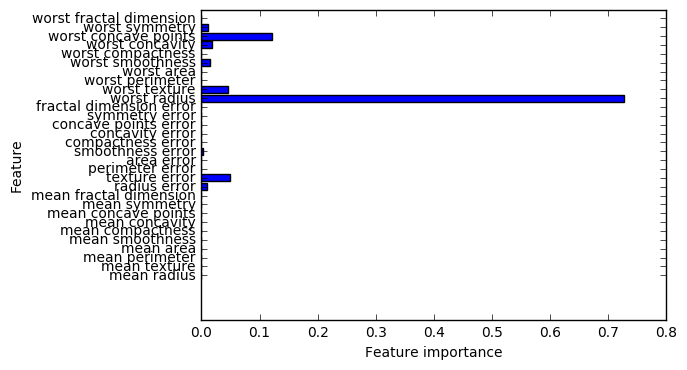

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(tree)

In contrast to coefficients in linear models, feature importances are always positive, and don't encode which class a feature is indicative of.  In fact, there might not be a simple relationship between features and class, as illustrated in the following two-dimensional dataset in which the feature on the y-axis has a non-monotonous relationship with the class label:

Feature importances: [ 0.  1.]


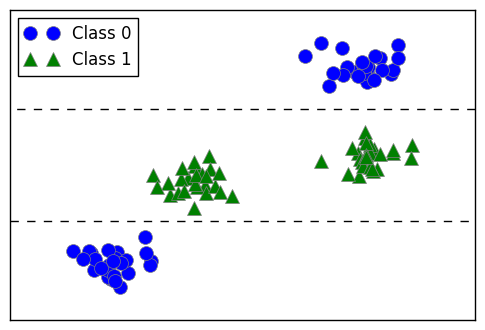

In [24]:
import mglearn

tree = mglearn.plots.plot_tree_not_monotone()

Here, the output class is non-monotonous, meaning we cannot say "a high vaue of x[0] means class 0, and a low value means class 1" (or vice versa).

All this applies to Decision Tree Regressors as well as Decision Tree classifiers, although Decision Tree Regressors are further constrained by being unable to extrapolate, or make predictions, outside of the training data.

To illustrate, consider the following dataset:

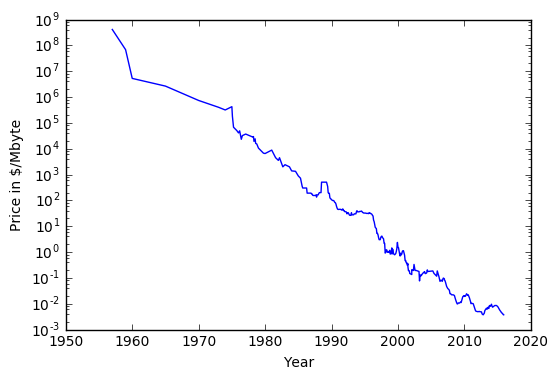

In [26]:
import pandas as pd

ram_prices = pd.read_csv("../data/ram_prices.csv")

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

Make a forecast for the years after 2000 using the historical data up to that point with the date as our only feature and compare the Decision Tree Regressor to a Linear Regression.

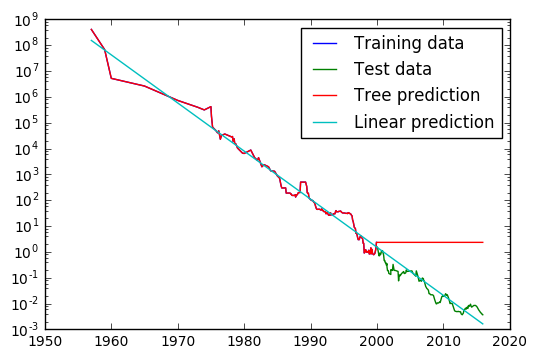

In [34]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
X_train = data_train.date[:, np.newaxis]
# use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price) 

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

The parameters to control model complexity are the pre-pruning parameters: `max_depth`, `max_leaf_nodes`, `min_samples_leaf`, etc.

Advantages:
  - Easily visualized and understood by non-experts
  - invariant to the scaling of the data (no preprocessing like normalization or standardization of features is needed) and work well when features are on completely different scales or are a mix or binary and continuous features
  
Downsides:
  - Tend to overfit, even with pruning
  - Provide poor generalization performance